In [184]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns

In [186]:
df = pd.read_csv('data/city_day.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Sort by Date to maintain temporal order
#df = df.sort_values(by=['Date']).reset_index(drop=True)

# since we are not using this as the target
df.drop(columns = 'AQI_Bucket', inplace = True)

#df['City'] = df['City'].astype('category')

df.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
0,Delhi,2015-01-01,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25,41.68,14.36,24.86,9.84,472.0
1,Delhi,2015-01-02,186.18,269.55,62.09,32.87,88.14,31.83,9.54,6.65,29.97,10.55,20.09,4.29,454.0
2,Delhi,2015-01-03,87.18,131.90,25.73,30.31,47.95,69.55,10.61,2.65,19.71,3.91,10.23,1.99,143.0
3,Delhi,2015-01-04,151.84,241.84,25.01,36.91,48.62,130.36,11.54,4.63,25.36,4.26,9.71,3.34,319.0
4,Delhi,2015-01-05,146.60,219.13,14.01,34.92,38.25,122.88,9.20,3.33,23.20,2.80,6.21,2.96,325.0


# EDA

In [98]:
import pandas as pd

# Missing values
def missing_values_table(df):
    df_excluded = df.drop(columns=['AQI'])
    mis_val = df_excluded.isnull().sum()
    mis_val_percent = 100 * df_excluded.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'}
    )

    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0
    ].sort_values('% of Total Values', ascending=False).round(1)

    print("Your selected dataframe has " + str(df_excluded.shape[1]) + " columns.\n"
          "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    return mis_val_table_ren_columns

missing_values = missing_values_table(df)

missing_values.style.background_gradient(cmap='Reds')

Your selected dataframe has 14 columns.
There are 12 columns that have missing values.


,Missing Values,% of Total Values
Xylene,15372,61.900000
PM10,7086,28.500000
NH3,6536,26.300000
Toluene,5826,23.400000
Benzene,3535,14.200000
NOx,1857,7.500000
O3,807,3.200000
PM2.5,678,2.700000
SO2,605,2.400000
CO,445,1.800000


In [141]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year_Month'] = df['Date'].apply(lambda x: x.strftime('%Y-%m'))

numeric_columns = df.select_dtypes(include=['float64', 'int64'])
corr_with_AQI = numeric_columns.corr().AQI.sort_values(ascending = False)
corr_with_AQI

AQI        1.000000
PM10       0.803313
CO         0.683346
PM2.5      0.659181
NO2        0.537071
SO2        0.490586
NOx        0.486450
NO         0.452191
Toluene    0.279992
NH3        0.252019
O3         0.198991
Xylene     0.165532
Benzene    0.044407
Name: AQI, dtype: float64

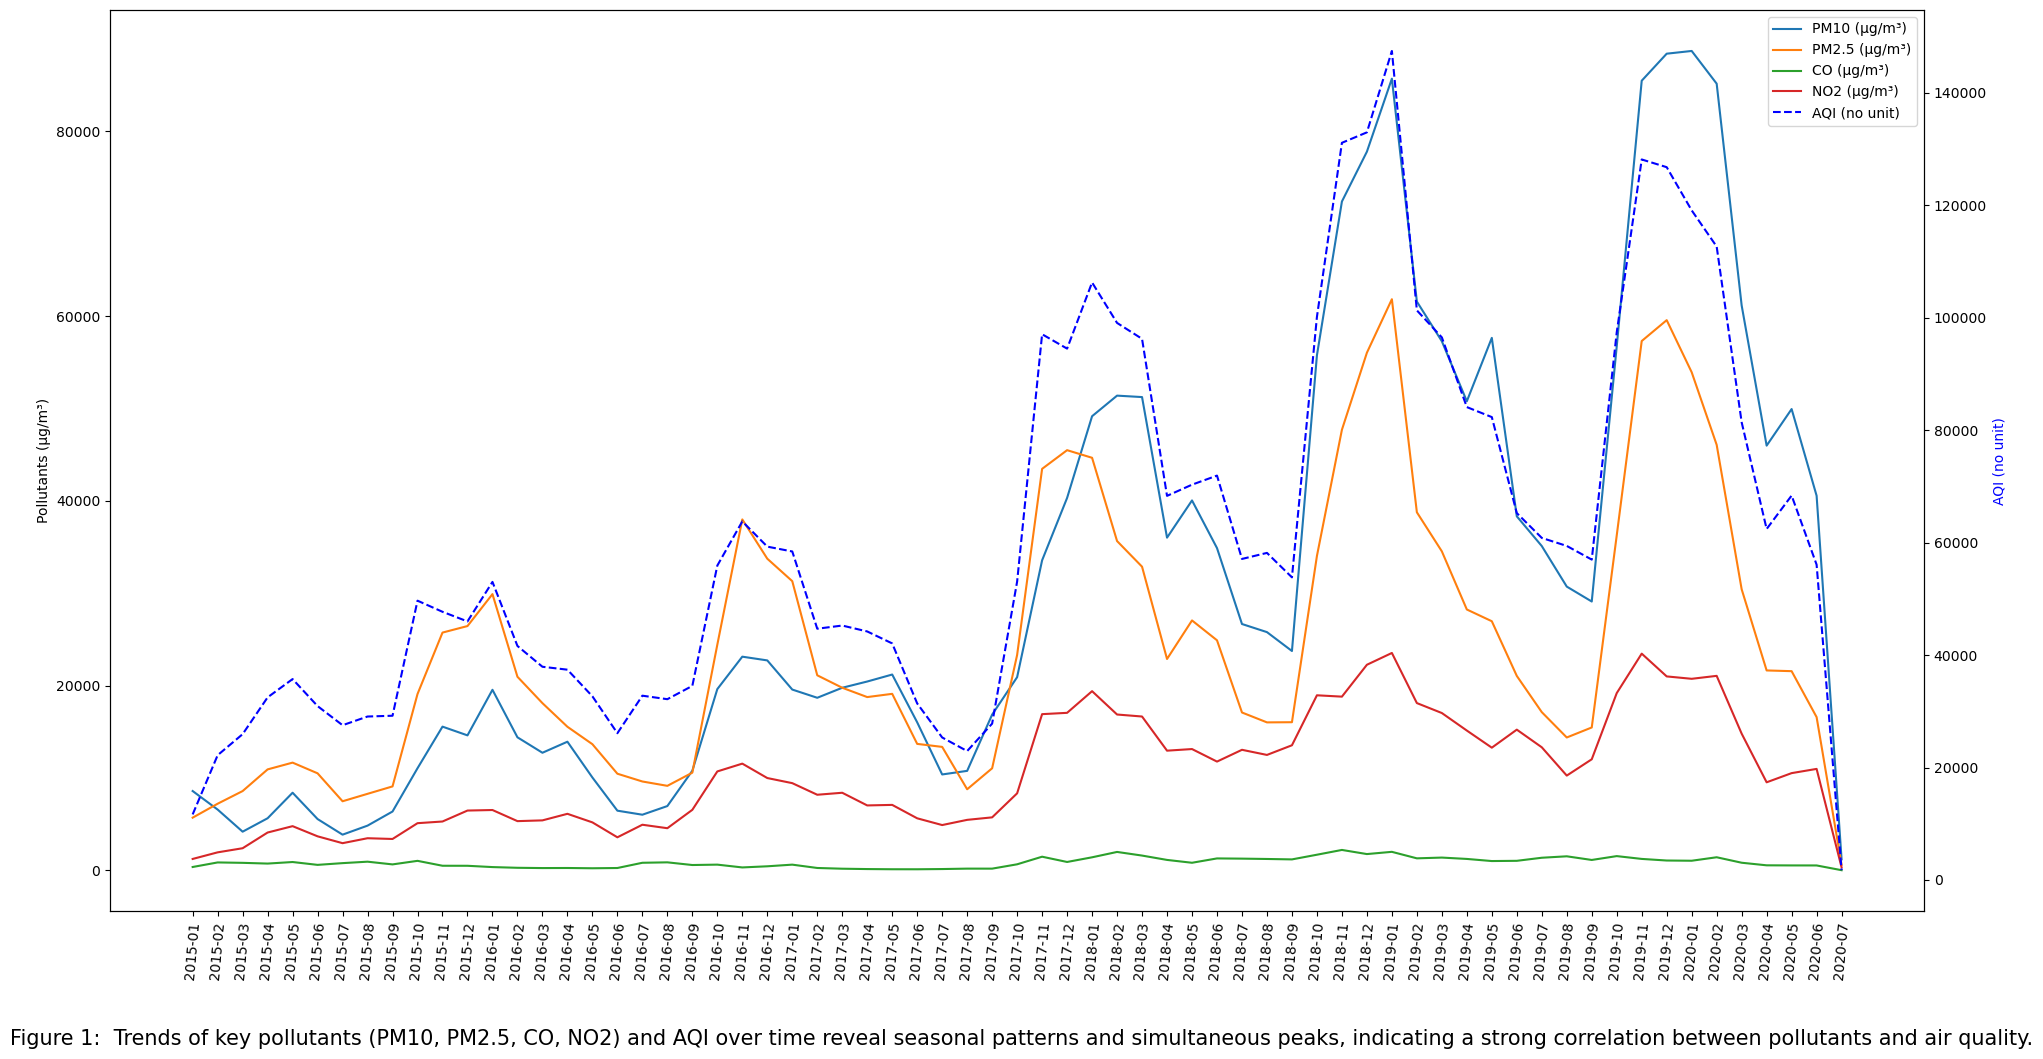

In [142]:
import matplotlib.pyplot as plt

# Filter the columns that are important to AQI (those with correlation > 0.5)
metrices = corr_with_AQI[corr_with_AQI > 0.5].index

# Group by 'Year_Month' and sum only numeric columns
df_grouped = df.groupby('Year_Month')[metrices].sum().reset_index()

# Create a figure with dual Y-axes
fig, ax1 = plt.subplots(figsize=(20, 10))

# Define the first y-axis variables (units: µg/m³ for PM10, PM2.5, CO, NO2)
pollutants_with_ug_m3 = ['PM10', 'PM2.5', 'CO', 'NO2']

# Plot pollutants with µg/m³ on the left y-axis
for col in pollutants_with_ug_m3:
    if col in df_grouped.columns:
        ax1.plot(df_grouped['Year_Month'], df_grouped[col], label=f"{col} (µg/m³)", linestyle="-")

# Set the first y-axis label
ax1.set_ylabel('Pollutants (µg/m³)')

# Create a second y-axis for AQI (no unit)
ax2 = ax1.twinx()
ax2.plot(df_grouped['Year_Month'], df_grouped['AQI'], label='AQI (no unit)', color='blue', linestyle="--")

# Set the second y-axis label
ax2.set_ylabel('AQI (no unit)', color='blue')

# Set x-tick labels with a rotation for readability
ax1.set_xticklabels(df_grouped['Year_Month'], rotation=85)

# Add a combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2)

# Adjust the layout and display the plot

plt.tight_layout()
plt.figtext(0.5, -0.05, 
            "Figure 1:  Trends of key pollutants (PM10, PM2.5, CO, NO2) and AQI over time reveal seasonal patterns and simultaneous peaks, indicating a strong correlation between pollutants and air quality.", 
            ha="center", fontsize=15)

plt.show()

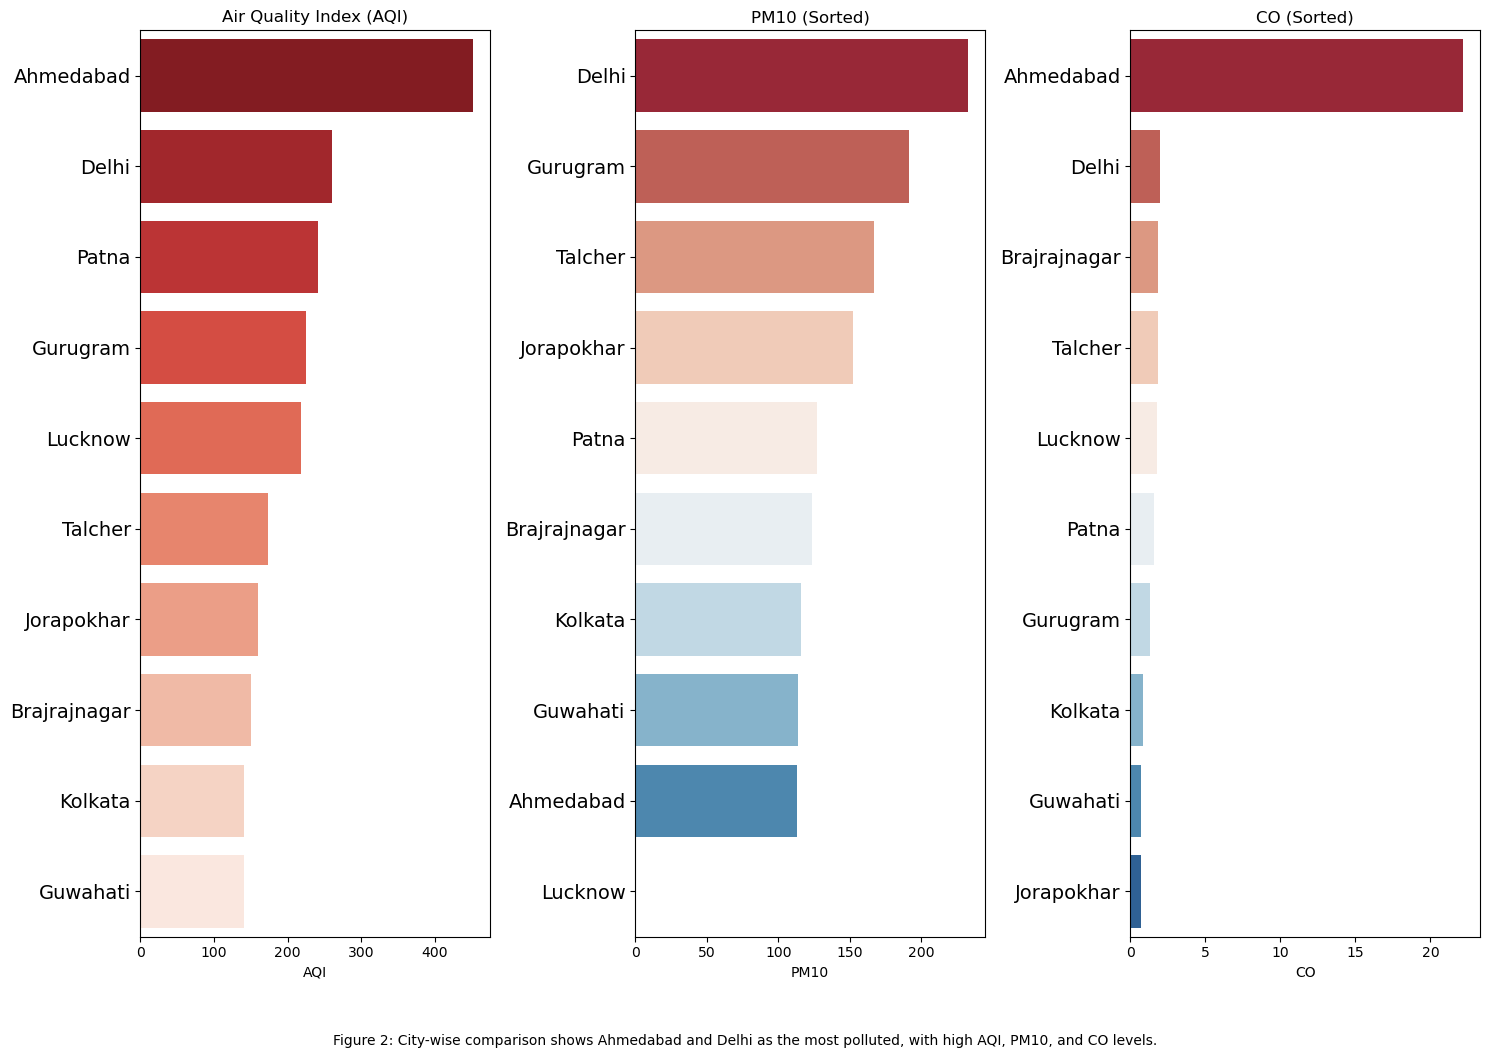

In [133]:
most_polluted = df[['City', 'AQI', 'PM10', 'CO']].groupby(['City']).mean().sort_values(by = 'AQI', ascending = False)

top_10_cities = most_polluted.head(10)

# Create the subplots for AQI, PM10, and CO
f, ax_ = plt.subplots(1, 3, figsize=(15, 10))  # Adjusted height for better readability

# Plot for AQI (already filtered by top 10)
bar1 = sns.barplot(x=top_10_cities.AQI,
                   y=top_10_cities.index,
                   palette='Reds_r',
                   ax=ax_[0])

# Plot for PM10, sorting values in descending order
sorted_by_pm10 = top_10_cities.sort_values(by='PM10', ascending=False)
bar2 = sns.barplot(x=sorted_by_pm10.PM10,
                   y=sorted_by_pm10.index,
                   palette='RdBu',
                   ax=ax_[1])

# Plot for CO, sorting values in descending order
sorted_by_co = top_10_cities.sort_values(by='CO', ascending=False)
bar3 = sns.barplot(x=sorted_by_co.CO,
                   y=sorted_by_co.index,
                   palette='RdBu',
                   ax=ax_[2])

# Titles for each plot
titles = ['Air Quality Index (AQI)', 'PM10 (Sorted)', 'CO (Sorted)']

# Apply formatting
for i in range(3):
    ax_[i].set_ylabel('')
    ax_[i].set_yticklabels(labels=ax_[i].get_yticklabels(), fontsize=14)
    ax_[i].set_title(titles[i])

# Adjust layout
f.tight_layout()
plt.figtext(0.5, -0.05, 
            "Figure 2: City-wise comparison shows Ahmedabad and Delhi as the most polluted, with high AQI, PM10, and CO levels.", 
            ha="center", fontsize=10)


plt.show()


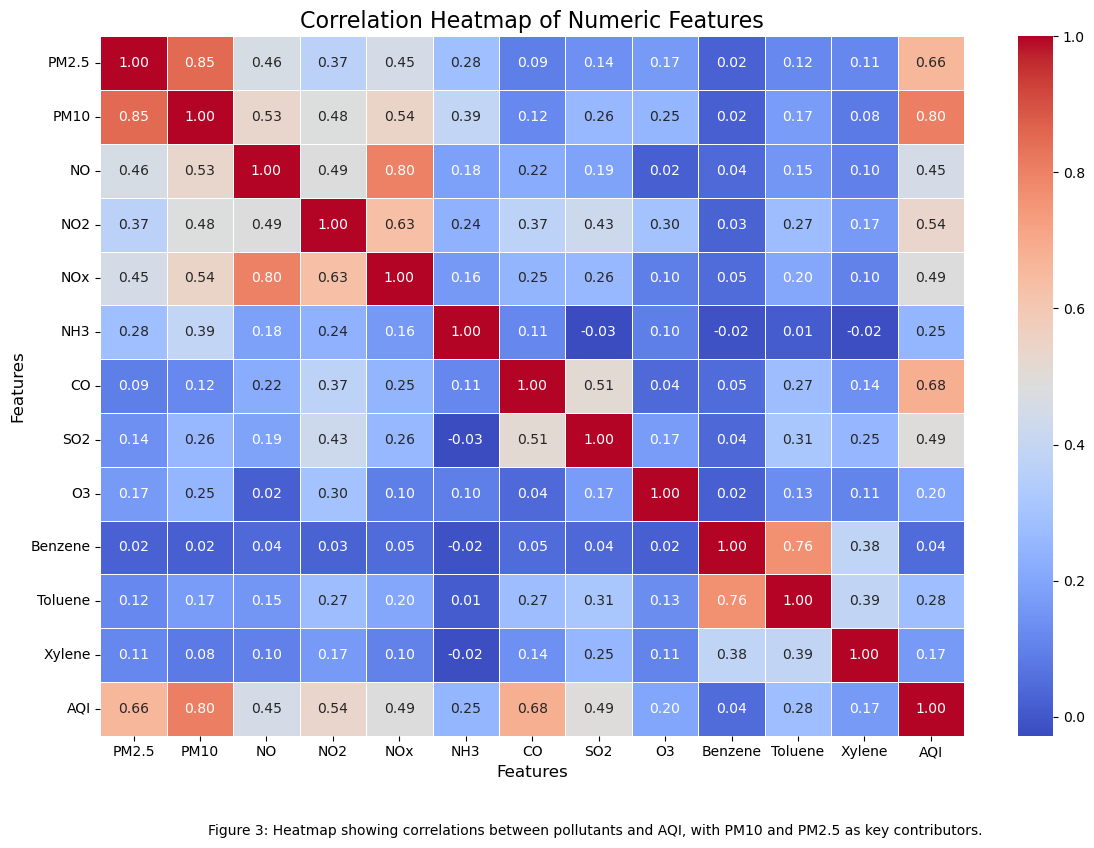

In [143]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
corr_matrix = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Add labels and title
plt.title('Correlation Heatmap of Numeric Features', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.figtext(0.5, -0.05, 
            "Figure 3: Heatmap showing correlations between pollutants and AQI, with PM10 and PM2.5 as key contributors.", 
            ha="center", fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

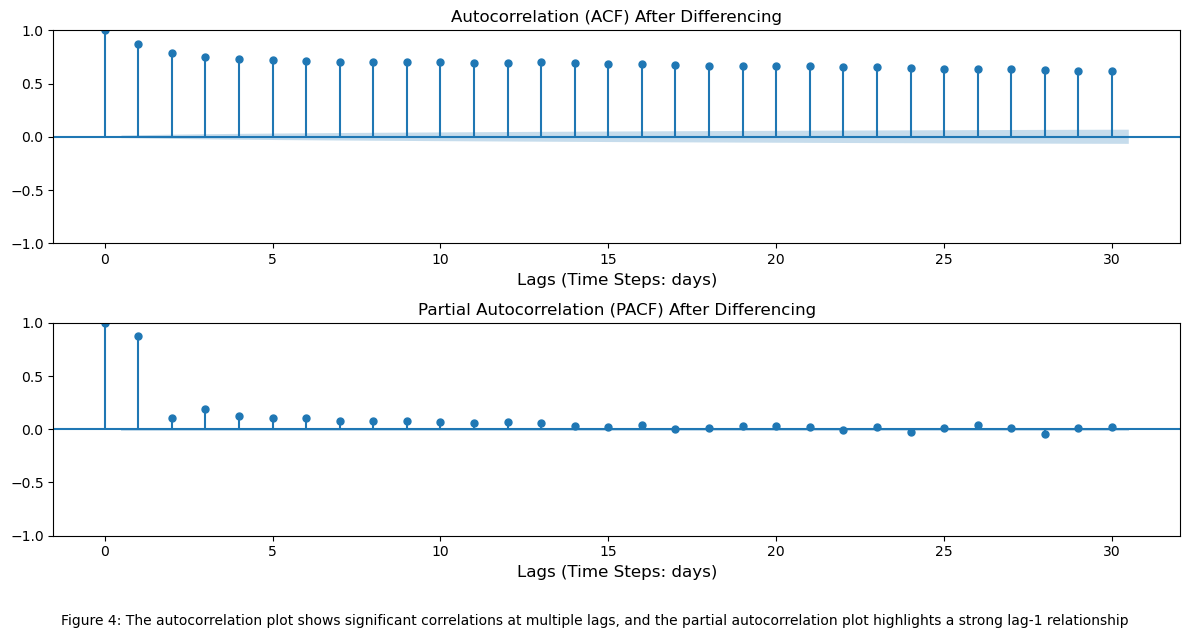

In [144]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Example data (ensure 'AQI' is properly differenced or preprocessed)
# Assuming `df` contains the AQI data already differenced (or raw if necessary)
# df['AQI_diff'] = df['AQI'].diff().dropna()

plt.figure(figsize=(12, 6))

# ACF Plot
plt.subplot(211)
plot_acf(df['AQI'], lags=30, ax=plt.gca())
plt.xlabel('Lags (Time Steps: days)', fontsize=12)  # Adding units (e.g., Time Steps)
plt.title('Autocorrelation (ACF) After Differencing')
#plt.figtext(0.5, -0.05, 
            #"Figure 1: The autocorrelation plot shows significant correlations at multiple lags, indicating strong temporal dependencies in the data", 
            #ha="center", fontsize=10)

# PACF Plot
plt.subplot(212)
plot_pacf(df['AQI'], lags=30, ax=plt.gca())
plt.xlabel('Lags (Time Steps: days)', fontsize=12)  # Adding units (e.g., Time Steps)
plt.title('Partial Autocorrelation (PACF) After Differencing')
plt.figtext(0.5, -0.05, 
            "Figure 4: The autocorrelation plot shows significant correlations at multiple lags, and the partial autocorrelation plot highlights a strong lag-1 relationship", 
            # suggesting that recent values primarily drive the current value.", 
            ha="center", fontsize=10)

plt.tight_layout()
plt.show()

# Preprocess

In [188]:
def add_lag_and_rolling_features(data):
    """
    Adds lagged features and rolling averages for the target column to the dataset.
    Preserves rows for predictive purposes by introducing NaN values for lagged/rolling calculations.
    """
    data = data.copy()
    data['AQI_lag_1'] = data['AQI'].shift(1)  # Lag by 1 row
    data['AQI_lag_2'] = data['AQI'].shift(2)  # Lag by 2 rows
    data['AQI_rolling_avg_2'] = data['AQI'].shift(1).rolling(2).mean()  # Rolling average of past 2 rows
    data['AQI_rolling_avg_3'] = data['AQI'].shift(1).rolling(3).mean()  # Rolling average of past 3 rows

    
    return data

# Apply the function to your dataset
df = add_lag_and_rolling_features(df)
df['City'] = df['City'].astype('category')
df = df.sort_values(by=['Date']).reset_index(drop=True)
df

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_lag_1,AQI_lag_2,AQI_rolling_avg_2,AQI_rolling_avg_3
0,Delhi,2015-01-01,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25,41.68,14.36,24.86,9.84,472.0,NaN,NaN,NaN,NaN
1,Delhi,2015-01-02,186.18,269.55,62.09,32.87,88.14,31.83,9.54,6.65,29.97,10.55,20.09,4.29,454.0,472.0,NaN,NaN,NaN
2,Delhi,2015-01-03,87.18,131.90,25.73,30.31,47.95,69.55,10.61,2.65,19.71,3.91,10.23,1.99,143.0,454.0,472.0,463.0,NaN
3,Delhi,2015-01-04,151.84,241.84,25.01,36.91,48.62,130.36,11.54,4.63,25.36,4.26,9.71,3.34,319.0,143.0,454.0,298.5,356.333333
4,Delhi,2015-01-05,146.60,219.13,14.01,34.92,38.25,122.88,9.20,3.33,23.20,2.80,6.21,2.96,325.0,319.0,143.0,231.0,305.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24845,Kolkata,2020-07-01,10.53,31.58,6.25,10.01,16.29,12.87,0.30,4.32,15.52,1.82,10.25,0.18,45.0,98.0,101.0,99.5,100.333333
24846,Shillong,2020-07-01,16.70,29.40,0.97,2.70,1.04,2.66,0.10,4.29,17.71,0.00,0.02,NaN,24.0,45.0,98.0,71.5,81.333333
24847,Jorapokhar,2020-07-01,NaN,102.38,20.90,14.11,NaN,7.38,1.67,10.57,18.23,NaN,NaN,NaN,86.0,24.0,45.0,34.5,55.666667
24848,Guwahati,2020-07-01,40.00,53.00,0.55,6.59,3.59,5.02,0.61,16.07,21.32,0.00,NaN,NaN,36.0,86.0,24.0,55.0,51.666667


In [189]:
# Step 3: Prepare train, validation, and test splits (temporal split)
train_ratio, val_ratio, test_ratio = 0.6, 0.2, 0.2
n_total = len(df)

n_train = int(n_total * train_ratio)
n_val = int(n_total * val_ratio)


#ensure temporal data
X_train = df.iloc[:n_train].drop(columns=['AQI', 'Date'])
y_train = df.iloc[:n_train]['AQI']

X_val = df.iloc[n_train:n_train + n_val].drop(columns=['AQI', 'Date'])
y_val = df.iloc[n_train:n_train + n_val]['AQI']

X_test = df.iloc[n_train + n_val:].drop(columns=['AQI', 'Date'])
y_test = df.iloc[n_train + n_val:]['AQI']

# Step 4: Preprocessing pipeline
numerical_cols = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']
numerical_cols += ['AQI_lag_1', 'AQI_lag_2', 'AQI_rolling_avg_2', 'AQI_rolling_avg_3']
categorical_cols = ['City']

numerical_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [190]:
print("\n--- Baseline Performance ---")
baseline_pred = [y_test.mean()] * len(y_test)
baseline_mse = mean_squared_error(y_test, baseline_pred)
baseline_r2 = r2_score(y_test, baseline_pred)

print(f"Baseline Test MSE: {baseline_mse:.4f}")
print(f"Baseline Test R²: {baseline_r2:.4f}")



--- Baseline Performance ---
Baseline Test MSE: 8099.0134
Baseline Test R²: 0.0000


In [191]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

def train_model(model, param_grid, n_splits, scoring, X_train, y_train, X_val, y_val, X_test, y_test, random_state):
    """
    Trains a model using GridSearchCV with time series cross-validation.

    Parameters:
        model (estimator): Machine learning model to train.
        param_grid (dict): Hyperparameter grid for GridSearchCV.
        n_splits (int): Number of splits for TimeSeriesSplit.
        scoring (str): Scoring metric for GridSearchCV.
        X_train, y_train: Training data.
        X_val, y_val: Validation data.
        X_test, y_test: Test data.
        random_state (int): Random state for reproducibility.

    Returns:
        dict: Dictionary with test metrics.
    """
    # Set random state for the model if applicable
    '''
    if hasattr(model, 'random_state') and random_state is not None:
        model.set_params(random_state=random_state)
    '''
    

    # Create a pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    

    # Time series cross-validation and grid search
    #这个n_split也可以改了看看
    tscv = TimeSeriesSplit(n_splits=n_splits)
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=tscv,
        scoring=scoring,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)
    
    # Best parameters and evaluation
    best_model = grid_search.best_estimator_
    y_val_pred = best_model.predict(X_val)
    y_test_pred = best_model.predict(X_test)

    # Calculate metrics
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print("\n--- Baseline Performance ---")
    baseline_pred = [y_test.mean()] * len(y_test)
    baseline_mse = mean_squared_error(y_test, baseline_pred)
    baseline_r2 = r2_score(y_test, baseline_pred)

    print(f"Baseline Test MSE: {baseline_mse:.4f}")
    print(f"Baseline Test R²: {baseline_r2:.4f}")

    print("\n--- Model Performance ---")
    #print(f"Validation MSE: {val_mse:.4f}, R²: {val_r2:.4f}")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test R²: {test_r2:.4f}")



    # Return test scores
    return {
        'random_state': random_state,
        'test_mse': test_mse,
        'test_r2': test_r2,
        'best_params': grid_search.best_params_
    }


# ML models

### Random Forest

In [31]:
# random forest
rf_param_grid = {
    'regressor__max_features': ['auto', 'sqrt', 'log2', None],
    'regressor__max_depth': [1, 2, 5, 10, 20, 30, 50, None]
}

rf_res = []
random_states = [42, 666, 100, 0, 322]
for i in random_states:
    model = RandomForestRegressor(n_estimators=500, random_state=i)
    rf_res.append(train_model(model, rf_param_grid, 5, 'neg_mean_squared_error', X_train, y_train, X_val, y_val, X_test, y_test, i))

rf_res

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
40 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
28 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, 


--- Baseline Performance ---
Baseline Test MSE: 11540.8737
Baseline Test R²: 0.0000

--- Model Performance ---
Test MSE: 517.6100
Test R²: 0.9551
Fitting 5 folds for each of 32 candidates, totalling 160 fits


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
40 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, 


--- Baseline Performance ---
Baseline Test MSE: 11540.8737
Baseline Test R²: 0.0000

--- Model Performance ---
Test MSE: 517.2302
Test R²: 0.9552
Fitting 5 folds for each of 32 candidates, totalling 160 fits


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
40 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
23 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/anita/opt/anaconda3/en


--- Baseline Performance ---
Baseline Test MSE: 11540.8737
Baseline Test R²: 0.0000

--- Model Performance ---
Test MSE: 517.2958
Test R²: 0.9552
Fitting 5 folds for each of 32 candidates, totalling 160 fits


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
40 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
28 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/anita/opt/anaconda3/en


--- Baseline Performance ---
Baseline Test MSE: 11540.8737
Baseline Test R²: 0.0000

--- Model Performance ---
Test MSE: 516.8037
Test R²: 0.9552
Fitting 5 folds for each of 32 candidates, totalling 160 fits


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
40 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, 


--- Baseline Performance ---
Baseline Test MSE: 11540.8737
Baseline Test R²: 0.0000

--- Model Performance ---
Test MSE: 509.6983
Test R²: 0.9558


[{'random_state': 42,
  'test_mse': 517.6100400209588,
  'test_r2': 0.9551498392295232,
  'best_params': {'regressor__max_depth': 30,
   'regressor__max_features': None}},
 {'random_state': 666,
  'test_mse': 517.2301661053185,
  'test_r2': 0.9551827547544777,
  'best_params': {'regressor__max_depth': 20,
   'regressor__max_features': None}},
 {'random_state': 100,
  'test_mse': 517.2958301159025,
  'test_r2': 0.9551770650630038,
  'best_params': {'regressor__max_depth': 20,
   'regressor__max_features': None}},
 {'random_state': 0,
  'test_mse': 516.803694756437,
  'test_r2': 0.9552197078795766,
  'best_params': {'regressor__max_depth': 50,
   'regressor__max_features': None}},
 {'random_state': 322,
  'test_mse': 509.6983429647038,
  'test_r2': 0.9558353763279265,
  'best_params': {'regressor__max_depth': 50,
   'regressor__max_features': None}}]

### XGBoost

In [192]:
xgb_param_grid = {
    'regressor__max_depth': [3, 5, 7, 10],         # Depth of the trees
    'regressor__reg_alpha': [0, 0.01, 0.1, 1],    # L1 regularization (alpha)
    'regressor__reg_lambda': [1, 5, 10, 20]       # L2 regularization (lambda)
}

from xgboost import XGBRegressor
xgb_res = []
random_states = [42, 666, 100, 0, 322]
for i in random_states:
    #model = XGBRegressor(n_estimators=10000, early_stopping_rounds=50, random_state=i)
    model = XGBRegressor(random_state=i) 
    xgb_res.append(train_model(model, xgb_param_grid, 5, 'neg_mean_squared_error', X_train, y_train, X_val, y_val, X_test, y_test, i))

xgb_res

Fitting 5 folds for each of 64 candidates, totalling 320 fits

--- Baseline Performance ---
Baseline Test MSE: 8099.0134
Baseline Test R²: 0.0000

--- Model Performance ---
Test MSE: 800.0442
Test R²: 0.9012
Fitting 5 folds for each of 64 candidates, totalling 320 fits

--- Baseline Performance ---
Baseline Test MSE: 8099.0134
Baseline Test R²: 0.0000

--- Model Performance ---
Test MSE: 800.0442
Test R²: 0.9012
Fitting 5 folds for each of 64 candidates, totalling 320 fits

--- Baseline Performance ---
Baseline Test MSE: 8099.0134
Baseline Test R²: 0.0000

--- Model Performance ---
Test MSE: 800.0442
Test R²: 0.9012
Fitting 5 folds for each of 64 candidates, totalling 320 fits

--- Baseline Performance ---
Baseline Test MSE: 8099.0134
Baseline Test R²: 0.0000

--- Model Performance ---
Test MSE: 800.0442
Test R²: 0.9012
Fitting 5 folds for each of 64 candidates, totalling 320 fits

--- Baseline Performance ---
Baseline Test MSE: 8099.0134
Baseline Test R²: 0.0000

--- Model Performance

[{'random_state': 42,
  'test_mse': 800.0441650973687,
  'test_r2': 0.9012170838277282,
  'best_params': {'regressor__max_depth': 3,
   'regressor__reg_alpha': 0.1,
   'regressor__reg_lambda': 20}},
 {'random_state': 666,
  'test_mse': 800.0441650973687,
  'test_r2': 0.9012170838277282,
  'best_params': {'regressor__max_depth': 3,
   'regressor__reg_alpha': 0.1,
   'regressor__reg_lambda': 20}},
 {'random_state': 100,
  'test_mse': 800.0441650973687,
  'test_r2': 0.9012170838277282,
  'best_params': {'regressor__max_depth': 3,
   'regressor__reg_alpha': 0.1,
   'regressor__reg_lambda': 20}},
 {'random_state': 0,
  'test_mse': 800.0441650973687,
  'test_r2': 0.9012170838277282,
  'best_params': {'regressor__max_depth': 3,
   'regressor__reg_alpha': 0.1,
   'regressor__reg_lambda': 20}},
 {'random_state': 322,
  'test_mse': 800.0441650973687,
  'test_r2': 0.9012170838277282,
  'best_params': {'regressor__max_depth': 3,
   'regressor__reg_alpha': 0.1,
   'regressor__reg_lambda': 20}}]

In [34]:
# missing values
import pandas as pd
from xgboost import XGBRegressor

df = df.sort_values(by=['Date']).reset_index(drop=True)

# Step 1: Identify Missing Patterns
def identify_missing_patterns(X):
    """
    Identify unique missing value patterns in the dataset.
    """
    mask = X.isnull()
    unique_patterns = mask.drop_duplicates()
    return unique_patterns, mask

# Step 2: Train Feature-Reduced Models
def train_feature_reduced_models(X_train, y_train, X_other):
    """
    Train feature-reduced models on X_train and predict missing values for X_other (X_val/X_test).
    """
    unique_patterns, mask = identify_missing_patterns(X_train)
    all_other_preds = pd.DataFrame(index=X_other.index)

    for idx, pattern in unique_patterns.iterrows():
        print(f"Processing pattern {idx + 1} of {len(unique_patterns)}...")

        # Filter rows with this pattern
        train_mask = (mask == pattern).all(axis=1)
        other_mask = (X_other.isnull() == pattern).all(axis=1)

        # Select columns without missing values for this pattern
        selected_columns = X_train.columns[~pattern.values]
        sub_X_train = X_train.loc[train_mask, selected_columns]
        sub_y_train = y_train.loc[train_mask]
        sub_X_other = X_other.loc[other_mask, selected_columns]

        # Skip if there's no data for this pattern
        if sub_X_train.empty or sub_X_other.empty:
            print(f"Skipping pattern {idx + 1} due to empty subsets.")
            continue

        # Train XGB model
        #early stopping不知道要不要加暂时删了
        #model = XGBRegressor(n_estimators=1000, random_state=42, early_stopping_rounds=50, enable_categorical=True)
        model = XGBRegressor(n_estimators=1000, random_state=42, enable_categorical=True)

        model.fit(sub_X_train, sub_y_train)

        # Get predictions for other data
        all_other_preds.loc[other_mask, 'pred'] = model.predict(sub_X_other)

    return all_other_preds

# Step 3: Fill Missing Values in a Dataset
def fill_missing_values_with_reduced_features(X, preds):
    """
    Fill missing values in X using the predictions from feature-reduced models.
    """
    X_filled = X.copy()
    for index, value in preds['pred'].items():
        X_filled.loc[index, X_filled.columns[X_filled.loc[index].isnull()]] = value
    return X_filled

# Step 4: Fill All Splits
def fill_missing_values_all_splits(X_train, y_train, X_val, X_test):
    """
    Fill missing values in X_train, X_val, and X_test using feature-reduced models trained on X_train.
    """
    # Fill X_val using models trained on X_train
    print("Filling X_val...")
    val_preds = train_feature_reduced_models(X_train, y_train, X_val)
    X_val_filled = fill_missing_values_with_reduced_features(X_val, val_preds)

    # Fill X_test using models trained on X_train
    print("Filling X_test...")
    test_preds = train_feature_reduced_models(X_train, y_train, X_test)
    X_test_filled = fill_missing_values_with_reduced_features(X_test, test_preds)

    # Fill X_train using self-contained models
    print("Filling X_train...")
    train_preds = train_feature_reduced_models(X_train, y_train, X_train)
    X_train_filled = fill_missing_values_with_reduced_features(X_train, train_preds)

    return X_train_filled, X_val_filled, X_test_filled

# Step 5: Call the Workflow
def fill_all(X_train, y_train, X_val, X_test):
    """
    Main workflow to fill missing values in all splits.
    """
    # Ensure input datasets are pandas DataFrames
    if not isinstance(X_train, pd.DataFrame):
        raise ValueError("X_train must be a pandas DataFrame.")
    if not isinstance(X_val, pd.DataFrame):
        raise ValueError("X_val must be a pandas DataFrame.")
    if not isinstance(X_test, pd.DataFrame):
        raise ValueError("X_test must be a pandas DataFrame.")

    # Fill missing values
    X_train_filled, X_val_filled, X_test_filled = fill_missing_values_all_splits(X_train, y_train, X_val, X_test)
    
    X_test_filled = X_test_filled.fillna(method='ffill')
    X_val_filled = X_val_filled.fillna(method='ffill')



    # Print Results
    print("Filled Train Dataset:")
    print(X_train_filled.head())
    print("Filled Validation Dataset:")
    print(X_val_filled.head())
    print("Filled Test Dataset:")
    print(X_test_filled.head())

    return X_train_filled, X_val_filled, X_test_filled


X_train_filled, X_val_filled, X_test_filled = fill_all(X_train, y_train, X_val, X_test)
X_train_filled

Filling X_val...
Processing pattern 1 of 116...
Skipping pattern 1 due to empty subsets.
Processing pattern 2 of 116...
Skipping pattern 2 due to empty subsets.
Processing pattern 3 of 116...
Skipping pattern 3 due to empty subsets.
Processing pattern 4 of 116...
Skipping pattern 4 due to empty subsets.
Processing pattern 260 of 116...
Skipping pattern 260 due to empty subsets.
Processing pattern 337 of 116...
Processing pattern 381 of 116...
Skipping pattern 381 due to empty subsets.
Processing pattern 498 of 116...
Skipping pattern 498 due to empty subsets.
Processing pattern 933 of 116...
Skipping pattern 933 due to empty subsets.
Processing pattern 954 of 116...
Skipping pattern 954 due to empty subsets.
Processing pattern 956 of 116...
Skipping pattern 956 due to empty subsets.
Processing pattern 1080 of 116...
Skipping pattern 1080 due to empty subsets.
Processing pattern 1194 of 116...
Skipping pattern 1194 due to empty subsets.
Processing pattern 1335 of 116...
Processing patte

/var/folders/3y/jh01kr7x6kj5gsrldxy4w_r40000gn/T/ipykernel_63412/1785707170.py:102: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test_filled = X_test_filled.fillna(method='ffill')
/var/folders/3y/jh01kr7x6kj5gsrldxy4w_r40000gn/T/ipykernel_63412/1785707170.py:103: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_val_filled = X_val_filled.fillna(method='ffill')


,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI_lag_1,AQI_lag_2,AQI_rolling_avg_2,AQI_rolling_avg_3
0,Ahmedabad,83.13,209.000000,6.93,28.71,33.720000,209.000000,6.93,49.52,59.76,0.02,0.00,3.140000,209.0,209.0,209.0,209.000000
1,Ahmedabad,79.84,328.000000,13.85,28.68,41.080000,328.000000,13.85,48.49,97.07,0.04,0.00,4.810000,209.0,328.0,328.0,328.000000
2,Ahmedabad,94.52,514.000000,24.39,32.66,52.610000,514.000000,24.39,67.39,111.33,0.24,0.01,7.670000,328.0,209.0,268.5,514.000000
3,Ahmedabad,135.99,782.000183,43.48,42.08,84.570000,782.000183,43.48,75.23,102.70,0.40,0.04,25.870000,514.0,328.0,421.0,350.333333
4,Ahmedabad,178.33,913.999878,54.56,35.31,72.800000,913.999878,54.56,55.04,107.38,0.46,0.06,35.610000,782.0,514.0,648.0,541.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14905,Jaipur,45.26,91.970000,11.56,37.89,95.999451,50.760000,0.19,6.85,36.47,0.00,0.04,95.999451,118.0,84.0,101.0,96.666667
14906,Jaipur,66.73,121.450000,14.64,48.71,127.999672,66.300000,0.25,7.87,51.03,0.00,0.61,127.999672,96.0,118.0,107.0,99.333333
14907,Jaipur,50.59,93.760000,17.51,47.48,108.999870,64.770000,0.16,6.44,1.59,0.00,0.34,108.999870,128.0,96.0,112.0,114.000000
14908,Jaipur,78.87,135.610000,19.56,54.73,139.000076,84.460000,0.23,7.86,1.55,0.00,0.64,139.000076,109.0,128.0,118.5,111.000000


## Elastic Net

In [65]:
elastic_net_param_grid = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1, 10], 
    'regressor__l1_ratio': [0.1, 0.3, 0.5, 0.7, 1.0]  
}

from sklearn.linear_model import ElasticNet
en_res = []
random_states = [42, 666, 100, 0, 322]
for i in random_states:
    model = ElasticNet(random_state=i) #n_estimators=500 
    en_res.append(train_model(model, elastic_net_param_grid, 5, 'neg_mean_squared_error', X_train_filled, y_train, X_val_filled, y_val, X_test_filled, y_test, i))

en_res


Fitting 5 folds for each of 25 candidates, totalling 125 fits


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.766e+04, tolerance: 2.138e+04
  model = cd_fast.enet_coordinate_descent(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.343e+05, tolerance: 2.621e+04
  model = cd_fast.enet_coordinate_descent(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the


--- Baseline Performance ---
Baseline Test MSE: 11540.8737
Baseline Test R²: 0.0000

--- Model Performance ---
Test MSE: 2588.5177
Test R²: 0.7757
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.766e+04, tolerance: 2.138e+04
  model = cd_fast.enet_coordinate_descent(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.343e+05, tolerance: 2.621e+04
  model = cd_fast.enet_coordinate_descent(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the


--- Baseline Performance ---
Baseline Test MSE: 11540.8737
Baseline Test R²: 0.0000

--- Model Performance ---
Test MSE: 2588.5177
Test R²: 0.7757
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.766e+04, tolerance: 2.138e+04
  model = cd_fast.enet_coordinate_descent(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.343e+05, tolerance: 2.621e+04
  model = cd_fast.enet_coordinate_descent(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the


--- Baseline Performance ---
Baseline Test MSE: 11540.8737
Baseline Test R²: 0.0000

--- Model Performance ---
Test MSE: 2588.5177
Test R²: 0.7757
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.766e+04, tolerance: 2.138e+04
  model = cd_fast.enet_coordinate_descent(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.343e+05, tolerance: 2.621e+04
  model = cd_fast.enet_coordinate_descent(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the


--- Baseline Performance ---
Baseline Test MSE: 11540.8737
Baseline Test R²: 0.0000

--- Model Performance ---
Test MSE: 2588.5177
Test R²: 0.7757
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.766e+04, tolerance: 2.138e+04
  model = cd_fast.enet_coordinate_descent(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.343e+05, tolerance: 2.621e+04
  model = cd_fast.enet_coordinate_descent(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the


--- Baseline Performance ---
Baseline Test MSE: 11540.8737
Baseline Test R²: 0.0000

--- Model Performance ---
Test MSE: 2588.5177
Test R²: 0.7757


[{'random_state': 42,
  'test_mse': 2588.5176711137537,
  'test_r2': 0.7757086904613153,
  'best_params': {'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.3}},
 {'random_state': 666,
  'test_mse': 2588.5176711137537,
  'test_r2': 0.7757086904613153,
  'best_params': {'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.3}},
 {'random_state': 100,
  'test_mse': 2588.5176711137537,
  'test_r2': 0.7757086904613153,
  'best_params': {'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.3}},
 {'random_state': 0,
  'test_mse': 2588.5176711137537,
  'test_r2': 0.7757086904613153,
  'best_params': {'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.3}},
 {'random_state': 322,
  'test_mse': 2588.5176711137537,
  'test_r2': 0.7757086904613153,
  'best_params': {'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.3}}]

## SVR

In [47]:
svr_param_grid = {
    'regressor__C': [1e-2, 1e-1, 1e0, 1e1, 1e2],        # Regularization parameter
    'regressor__gamma': [1e-3, 1e-1, 1e1, 1e3, 1e5]  # Kernel coefficient
}

from sklearn.svm import SVR
svr_res = []
model = SVR() #n_estimators=500 
svr_res.append(train_model(model, svr_param_grid, 5, 'neg_mean_squared_error', X_train_filled, y_train, X_val_filled, y_val, X_test_filled, y_test, i))

svr_res

Fitting 5 folds for each of 25 candidates, totalling 125 fits

--- Baseline Performance ---
Baseline Test MSE: 11540.8737
Baseline Test R²: 0.0000

--- Model Performance ---
Test MSE: 2094.8095
Test R²: 0.8185


[{'random_state': 322,
  'test_mse': 2094.809527244552,
  'test_r2': 0.8184877865262423,
  'best_params': {'regressor__C': 10.0, 'regressor__gamma': 0.1}}]

### Uncertainty

In [48]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder

# Preprocess categorical columns
def preprocess_data(X):
    """
    Preprocesses the feature matrix by encoding categorical columns.

    Parameters:
        X (DataFrame): Feature matrix including categorical columns.

    Returns:
        DataFrame: Encoded feature matrix.
    """
    # Identify categorical columns
    cat_cols = X.select_dtypes(include=['object', 'category']).columns

    # One-Hot Encode categorical columns
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    X_encoded = pd.DataFrame(encoder.fit_transform(X[cat_cols]))

    # Drop original categorical columns and concatenate encoded columns
    X = X.drop(columns=cat_cols)
    X_encoded.columns = encoder.get_feature_names_out(cat_cols)
    X = pd.concat([X, X_encoded], axis=1)

    return X

# Function to calculate model uncertainty
def calculate_rf_uncertainty(X, y, n_splits=10, test_size=0.2, random_state=42):
    """
    Calculates prediction uncertainty using Random Forest and bootstrapping.
    
    Parameters:
        X (DataFrame): Feature matrix.
        y (Series): Target variable.
        n_splits (int): Number of bootstrapped splits.
        test_size (float): Fraction of data to use as test set.
        random_state (int): Random seed for reproducibility.
        
    Returns:
        dict: Dictionary containing mean predictions and uncertainty.
    """
    # Preprocess the data
    X = preprocess_data(X)
    
    # Store predictions for each resample
    all_test_preds = []
    
    # Repeated bootstrapping
    for i in range(n_splits):
        print(f"Running split {i+1}/{n_splits}...")
        
        # Resample the data (bootstrapping)
        X_resampled, y_resampled = resample(X, y, random_state=random_state+i)
        X_train, X_test, y_train, y_test = train_test_split(
            X_resampled, y_resampled, test_size=test_size, random_state=random_state+i
        )
        
        # Train Random Forest
        model = RandomForestRegressor(n_estimators=100, random_state=random_state+i, n_jobs=-1)
        model.fit(X_train, y_train)
        
        # Predict on the same test set for consistency
        y_pred = model.predict(X_test)
        all_test_preds.append(y_pred)
        
        # Print RMSE for each iteration
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"   RMSE for split {i+1}: {rmse:.4f}")
    
    # Combine predictions into an array
    all_test_preds = np.array(all_test_preds)
    
    # Calculate mean prediction and uncertainty (standard deviation)
    mean_preds = np.mean(all_test_preds, axis=0)
    uncertainty = np.std(all_test_preds, axis=0)
    
    return {'mean_preds': mean_preds, 'uncertainty': uncertainty}

# Example usage
# Assume X_train and y_train are your feature matrix and target variable
# Replace this with your actual data
X_train_encoded = preprocess_data(X_train)
results = calculate_rf_uncertainty(X_train_encoded, y_train, n_splits=10, test_size=0.2)

# Display the results
print("Mean predictions:", results['mean_preds'][:5])  # First 5 mean predictions
print("Uncertainty (std):", results['uncertainty'][:5])  # First 5 uncertainties


Running split 1/10...
   RMSE for split 1: 40.0660
Running split 2/10...
   RMSE for split 2: 36.8813
Running split 3/10...
   RMSE for split 3: 24.9983
Running split 4/10...
   RMSE for split 4: 39.1518
Running split 5/10...
   RMSE for split 5: 41.8731
Running split 6/10...
   RMSE for split 6: 33.4367
Running split 7/10...
   RMSE for split 7: 32.2219
Running split 8/10...
   RMSE for split 8: 34.7119
Running split 9/10...
   RMSE for split 9: 31.2326
Running split 10/10...
   RMSE for split 10: 28.8241
Mean predictions: [153.984 124.977 156.086 146.187 162.256]
Uncertainty (std): [ 97.39201242  74.68968711  98.54257721 122.65424771 106.41273553]


# Results

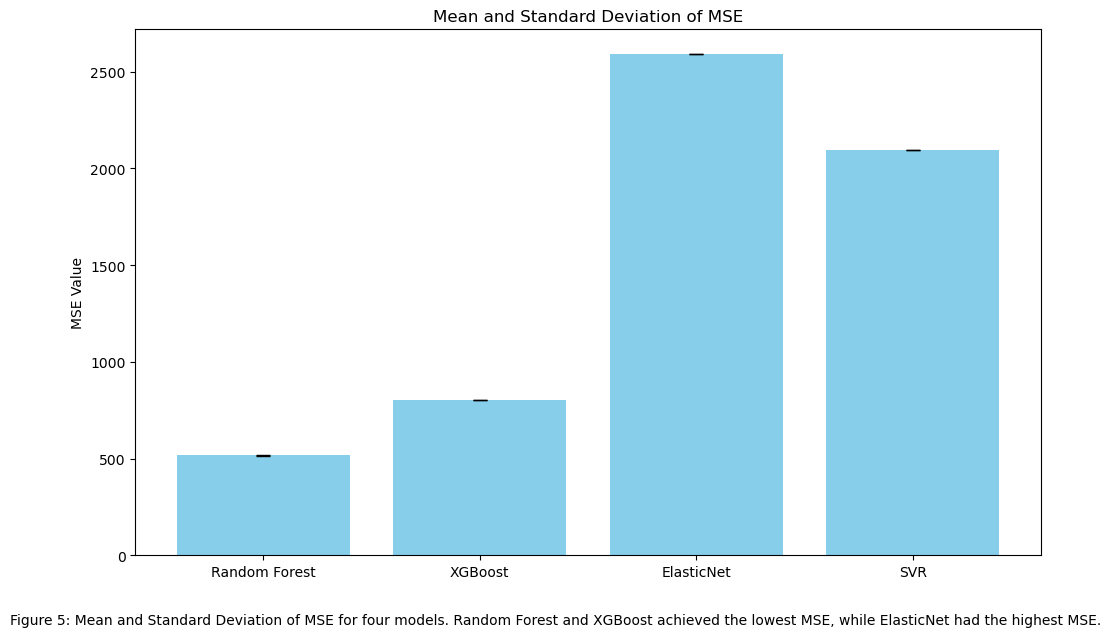

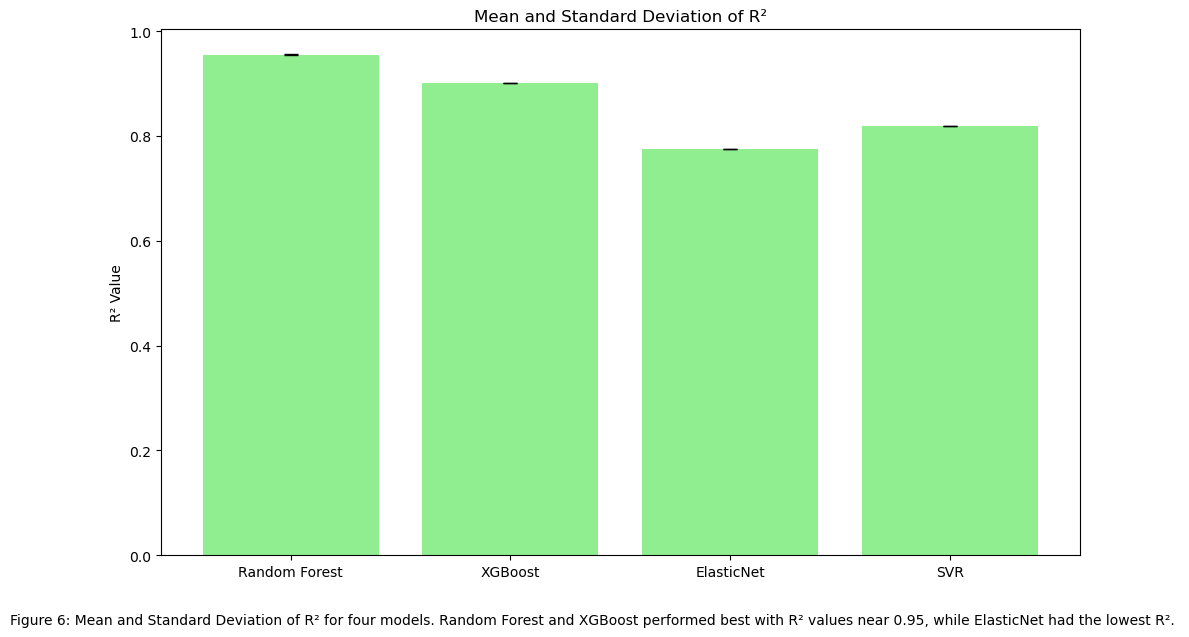

In [193]:
model_results = {"Random Forest": rf_res, "XGBoost": xgb_res, "ElasticNet": en_res, "SVR": svr_res}


# Function to calculate mean and std for MSE and R²
def calculate_metrics(results):
    metrics_summary = {}
    for model, runs in results.items():
        mse_values = [run["test_mse"] for run in runs]
        r2_values = [run["test_r2"] for run in runs]

        metrics_summary[model] = {
            "mse_mean": np.mean(mse_values),
            "mse_std": np.std(mse_values),
            "r2_mean": np.mean(r2_values),
            "r2_std": np.std(r2_values),
        }
    return metrics_summary

# Calculate metrics
metrics_summary = calculate_metrics(model_results)

# Extract data for plotting
models = list(metrics_summary.keys())
mse_means = [metrics_summary[model]["mse_mean"] for model in models]
mse_stds = [metrics_summary[model]["mse_std"] for model in models]
r2_means = [metrics_summary[model]["r2_mean"] for model in models]
r2_stds = [metrics_summary[model]["r2_std"] for model in models]

# Plot MSE with error bars
plt.figure(figsize=(10, 6))
plt.bar(models, mse_means, yerr=mse_stds, capsize=5, color="skyblue")
plt.ylabel("MSE Value")
plt.title("Mean and Standard Deviation of MSE")
plt.tight_layout()
plt.figtext(0.5, -0.05, 
            "Figure 5: Mean and Standard Deviation of MSE for four models. Random Forest and XGBoost achieved the lowest MSE, while ElasticNet had the highest MSE.", 
            ha="center", fontsize=10)
plt.show()

# Plot R² with error bars
plt.figure(figsize=(10, 6))
plt.bar(models, r2_means, yerr=r2_stds, capsize=5, color="lightgreen")
plt.ylabel("R² Value")
plt.title("Mean and Standard Deviation of R²")
plt.tight_layout()
plt.figtext(0.5, -0.05, 
            "Figure 6: Mean and Standard Deviation of R² for four models. Random Forest and XGBoost performed best with R² values near 0.95, while ElasticNet had the lowest R². ", 
            ha="center", fontsize=10)
plt.show()




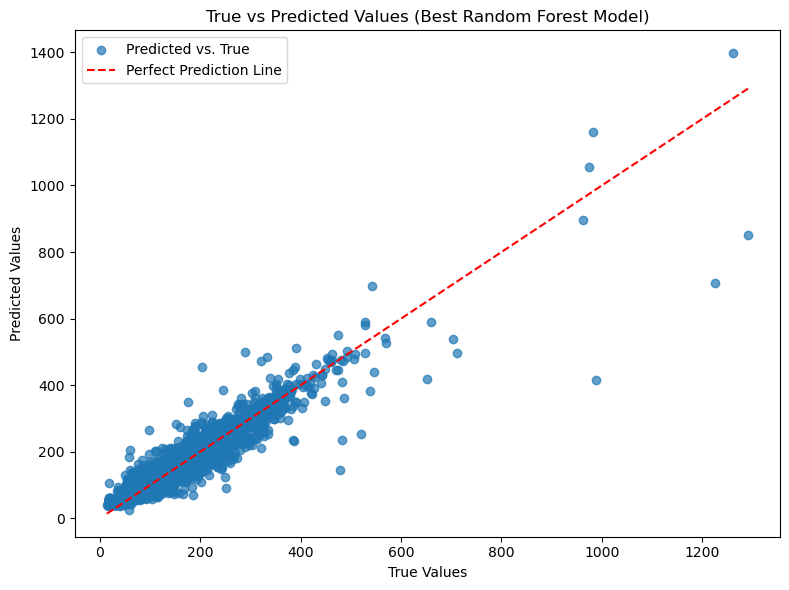

In [201]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Best parameters from GridSearchCV
best_params = {'regressor__max_depth': 50, 'regressor__max_features': None}

# Pipeline with best model
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Recreate pipeline using best parameters
best_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=500,
        max_depth=50,
        max_features=None,
        random_state=322
    ))
])

# Fit the pipeline on training data
best_model_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = best_model_pipeline.predict(X_test)

# Evaluate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


# Plot true vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, label="Predicted vs. True")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Prediction Line")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values (Best Random Forest Model)")
plt.legend()
plt.tight_layout()
plt.show()


In [203]:
joblib.dump(best_model_pipeline, "results/best_rf_model.pkl")
print("Best model saved to 'results/best_rf_model.pkl'")

# Load the model
loaded_model = joblib.load("results/best_rf_model.pkl")
print("Best model loaded successfully")

Best model saved to 'results/best_rf_model.pkl'
Best model loaded successfully


# interpret

In [52]:
import shap

Test MSE: 509.698
Test R²: 0.956


100%|===================| 4969/4970 [24:13<00:00]        

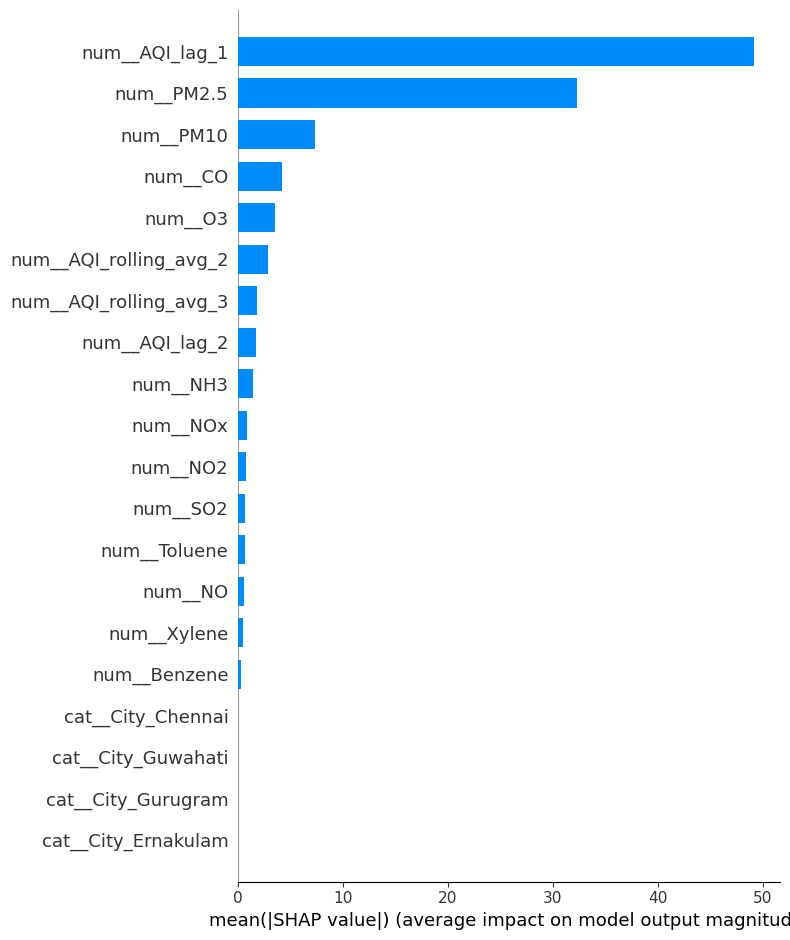

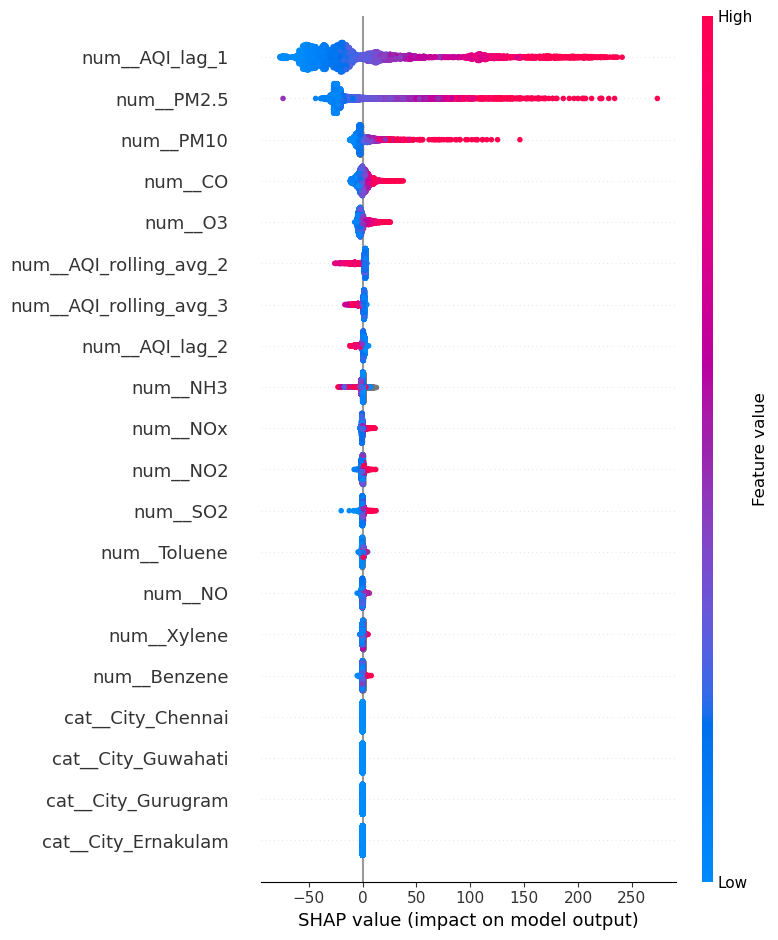

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [66]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Train the best model
model = RandomForestRegressor(n_estimators=500, random_state=322)
model.fit(X_train_preprocessed, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test_preprocessed)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {mse:.3f}")
print(f"Test R²: {r2:.3f}")

# SHAP Analysis
explainer = shap.Explainer(model, X_test_preprocessed)
shap_values = explainer(X_test_preprocessed)

# Plot SHAP summary (bar)
feature_names = preprocessor.get_feature_names_out()
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=feature_names, plot_type="bar")

# Plot SHAP summary (detailed)
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=feature_names)

# Permutation Importance
def compute_permutation_importance(model, X_test, y_test, nr_runs=10):
    """
    Computes permutation importance using MSE difference.

    Parameters:
        model: Trained model
        X_test: Test feature set
        y_test: Test target set
        nr_runs: Number of times to shuffle each feature

    Returns:
        scores: Permutation importance scores
        sorted_indices: Feature indices sorted by importance
    """
    ftr_names = X_test.columns  # Feature names
    baseline_predictions = model.predict(X_test)
    baseline_mse = mean_squared_error(y_test, baseline_predictions)
    scores = np.zeros([len(ftr_names), nr_runs])  # Store MSE scores for each feature

    # Loop through each feature and compute permutation importance using MSE
    for i, feature in enumerate(ftr_names):
        print(f"Shuffling {feature}")
        mse_scores = []
        for j in range(nr_runs):
            # Shuffle the feature
            X_test_shuffled = X_test.copy()
            X_test_shuffled[feature] = np.random.permutation(X_test[feature].values)
            # Predict and compute MSE
            shuffled_predictions = model.predict(X_test_shuffled)
            mse_scores.append(mean_squared_error(y_test, shuffled_predictions))
        scores[i] = mse_scores

    # Sort features by mean importance
    sorted_indices = np.argsort(np.mean(scores, axis=1))  # Ascending order
    return scores, sorted_indices, baseline_mse

# Calculate permutation importance
# Convert X_test_preprocessed to DataFrame with feature names
X_test_df = pd.DataFrame(X_test_preprocessed, columns=preprocessor.get_feature_names_out())
# fixed here

# Compute permutation importance
perm_scores, perm_sorted_indices, baseline_mse = compute_permutation_importance(model, X_test_df, y_test)

# Plot permutation importance
plt.figure(figsize=(10, 8))
plt.boxplot(perm_scores[perm_sorted_indices].T, vert=False, labels=feature_names[perm_sorted_indices])
plt.axvline(baseline_mse, color='blue', linestyle='--', label='Baseline MSE')
plt.title("Permutation Importances (Test Set)")
plt.xlabel("MSE with Shuffled Feature")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# 再跑这个
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Best parameters from GridSearchCV
best_params = {'regressor__max_depth': 50, 'regressor__max_features': None}

# Pipeline with best model
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Recreate pipeline using best parameters
best_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=500,
        max_depth=50,
        max_features=None,
        random_state=322
    ))
])

# Fit the pipeline on training data
best_model_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = best_model_pipeline.predict(X_test)

# Evaluate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
#print(f"Test MSE: {mse:.3f}")
#print(f"Test R²: {r2:.3f}")



In [ ]:
print(f"Test MSE: {mse:.3f}")
print(f"Test R²: {r2:.3f}")

In [ ]:

# Plot true vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, label="Predicted vs. True")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Prediction Line")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values (Best Random Forest Model)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 跑前面的
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Train the best model
model = RandomForestRegressor(n_estimators=500, random_state=322)
model.fit(X_train_preprocessed, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test_preprocessed)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
#print(f"Test MSE: {mse:.3f}")
#print(f"Test R²: {r2:.3f}")

# SHAP Analysis
explainer = shap.Explainer(model, X_test_preprocessed)
shap_values = explainer(X_test_preprocessed)

# Plot SHAP summary (bar)
feature_names = preprocessor.get_feature_names_out()
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=feature_names, plot_type="bar")

# Plot SHAP summary (detailed)
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=feature_names)

# Permutation Importance
def compute_permutation_importance(model, X_test, y_test, nr_runs=10):
    """
    Computes permutation importance using MSE difference.

    Parameters:
        model: Trained model
        X_test: Test feature set
        y_test: Test target set
        nr_runs: Number of times to shuffle each feature

    Returns:
        scores: Permutation importance scores
        sorted_indices: Feature indices sorted by importance
    """
    ftr_names = X_test.columns  # Feature names
    baseline_predictions = model.predict(X_test)
    baseline_mse = mean_squared_error(y_test, baseline_predictions)
    scores = np.zeros([len(ftr_names), nr_runs])  # Store MSE scores for each feature

    # Loop through each feature and compute permutation importance using MSE
    for i, feature in enumerate(ftr_names):
        print(f"Shuffling {feature}")
        mse_scores = []
        for j in range(nr_runs):
            # Shuffle the feature
            X_test_shuffled = X_test.copy()
            X_test_shuffled[feature] = np.random.permutation(X_test[feature].values)
            # Predict and compute MSE
            shuffled_predictions = model.predict(X_test_shuffled)
            mse_scores.append(mean_squared_error(y_test, shuffled_predictions))
        scores[i] = mse_scores

    # Sort features by mean importance
    sorted_indices = np.argsort(np.mean(scores, axis=1))  # Ascending order
    return scores, sorted_indices, baseline_mse

# Calculate permutation importance
# Convert X_test_preprocessed to DataFrame with feature names
X_test_df = pd.DataFrame(X_test_preprocessed, columns=preprocessor.get_feature_names_out())

# Compute permutation importance
perm_scores, perm_sorted_indices, baseline_mse = compute_permutation_importance(model, X_test_df, y_test)

# Plot permutation importance
plt.figure(figsize=(10, 8))
plt.boxplot(perm_scores[perm_sorted_indices].T, vert=False, labels=feature_names[perm_sorted_indices])
plt.axvline(baseline_mse, color='blue', linestyle='--', label='Baseline MSE')
plt.title("Permutation Importances (Test Set)")
plt.xlabel("MSE with Shuffled Feature")
plt.legend()
plt.tight_layout()
plt.show()


Force plot for index 0:


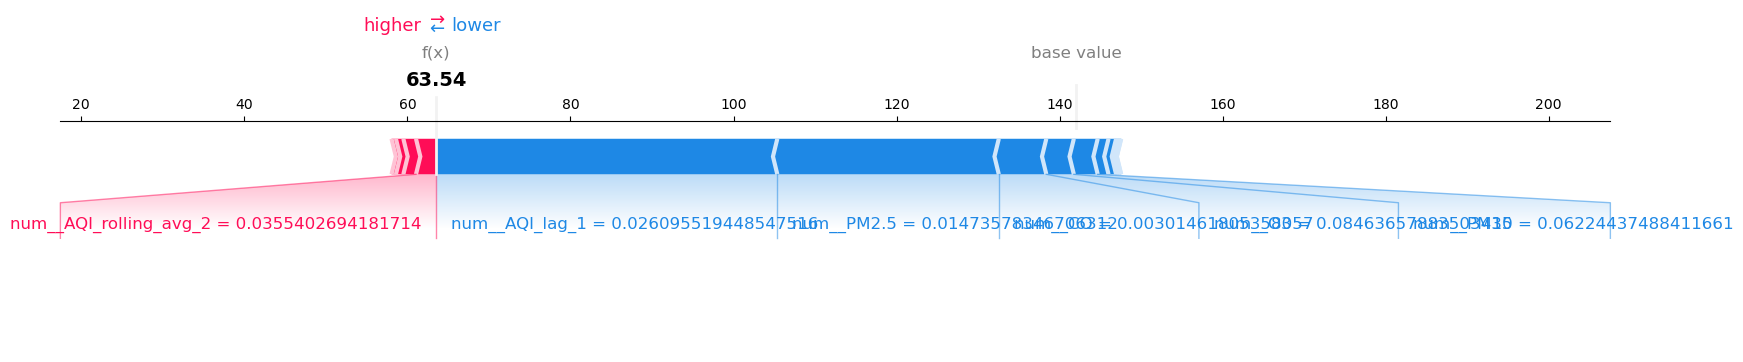

Force plot for index 100:


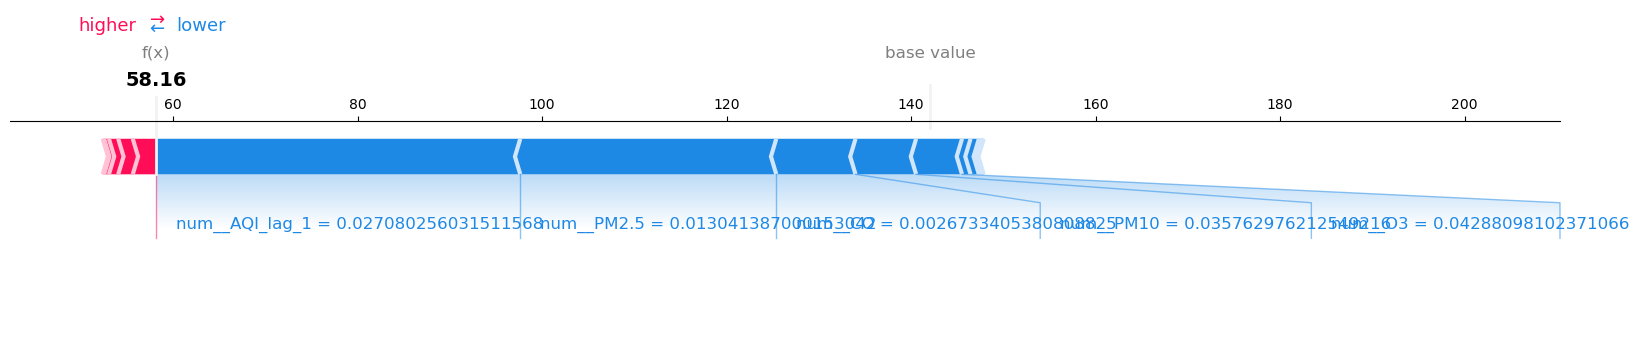

Force plot for index 200:


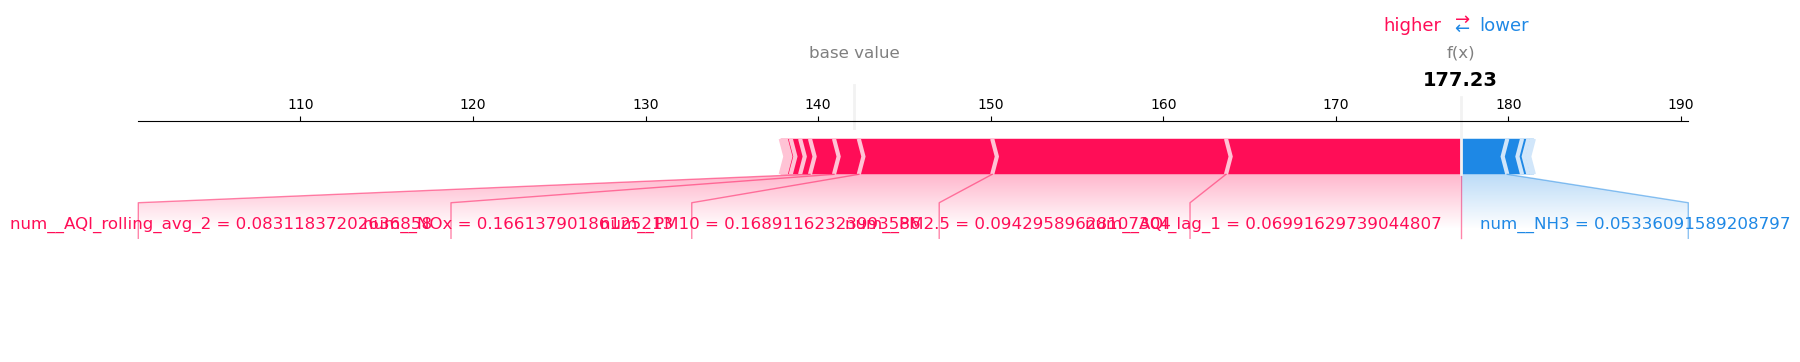

In [94]:
indices = [0, 100, 200]

for idx in indices:
    print(f"Force plot for index {idx}:")
    shap.force_plot(
        base_value=shap_values[idx].base_values,
        shap_values=shap_values[idx].values,
        features=X_test_preprocessed.iloc[idx],
        feature_names=feature_names,
        matplotlib=True
    )
    plt.show()

Force plot for index 78:


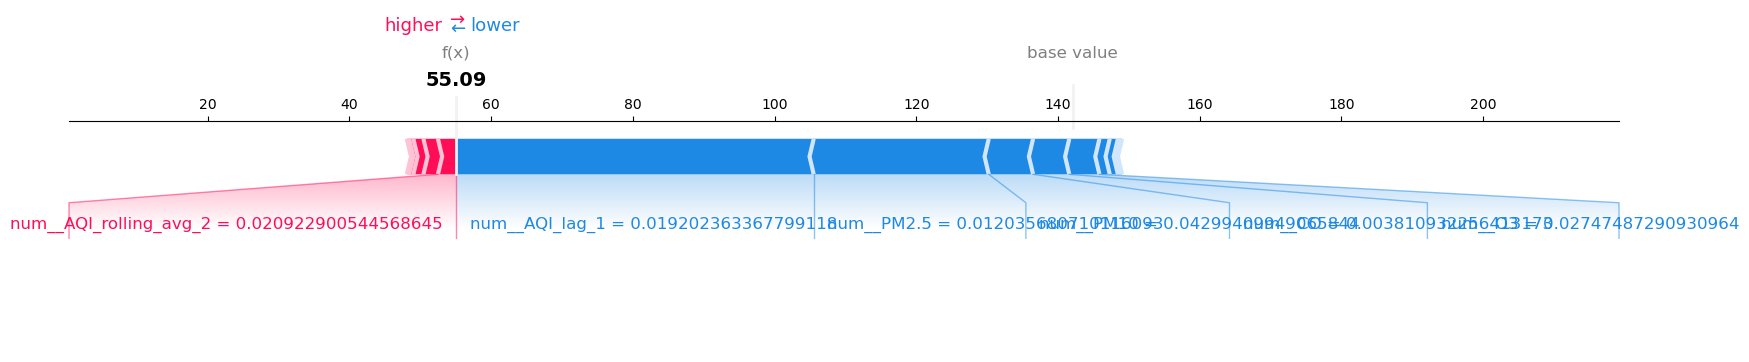

Force plot for index 120:


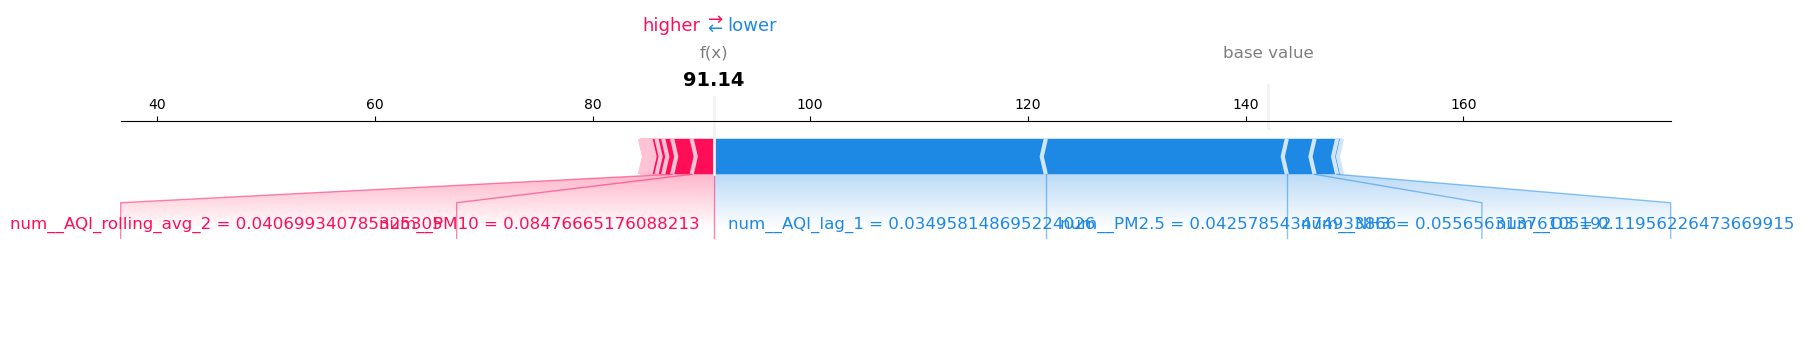

Force plot for index 180:


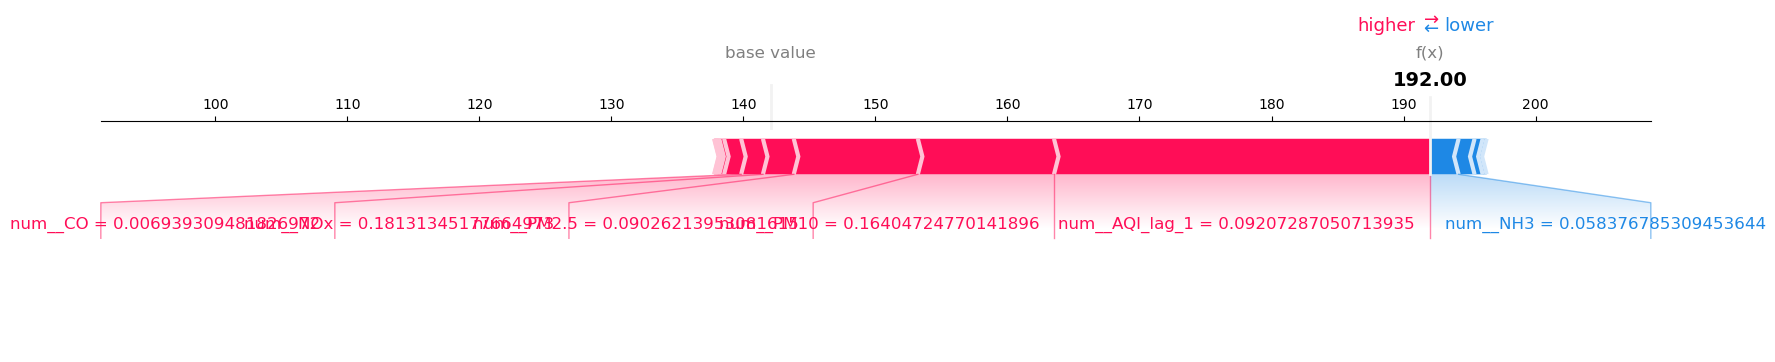

In [121]:
indices = [78, 120, 180]

for idx in indices:
    print(f"Force plot for index {idx}:")
    shap.force_plot(
        base_value=shap_values[idx].base_values,
        shap_values=shap_values[idx].values,
        features=X_test_preprocessed.iloc[idx],
        feature_names=feature_names,
        matplotlib=True
    )
    plt.show()

/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Baseline Test Score (MSE): 509.698
Shuffling num__PM2.5


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 5277.158 +/- 109.953
Shuffling num__PM10


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 955.908 +/- 49.285
Shuffling num__NO


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 514.384 +/- 2.533
Shuffling num__NO2


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 509.730 +/- 1.770
Shuffling num__NOx


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 512.560 +/- 1.567
Shuffling num__NH3


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 563.744 +/- 5.905
Shuffling num__CO


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 668.234 +/- 5.057
Shuffling num__SO2


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 503.568 +/- 1.054
Shuffling num__O3


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 564.871 +/- 3.202
Shuffling num__Benzene


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 511.074 +/- 0.899
Shuffling num__Toluene


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 507.901 +/- 1.288
Shuffling num__Xylene


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 510.391 +/- 0.499
Shuffling num__AQI_lag_1


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 9006.837 +/- 221.663
Shuffling num__AQI_lag_2


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 540.677 +/- 2.058
Shuffling num__AQI_rolling_avg_2


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 550.390 +/- 4.109
Shuffling num__AQI_rolling_avg_3


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 534.665 +/- 3.614
Shuffling cat__City_Ahmedabad


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 509.698 +/- 0.000
Shuffling cat__City_Aizawl


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 509.698 +/- 0.000
Shuffling cat__City_Amaravati


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 509.698 +/- 0.000
Shuffling cat__City_Amritsar


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 509.698 +/- 0.000
Shuffling cat__City_Bengaluru


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 509.698 +/- 0.000
Shuffling cat__City_Bhopal


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 509.698 +/- 0.000
Shuffling cat__City_Brajrajnagar


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 509.698 +/- 0.000
Shuffling cat__City_Chandigarh


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 509.698 +/- 0.000
Shuffling cat__City_Chennai


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 509.698 +/- 0.000
Shuffling cat__City_Coimbatore


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 509.698 +/- 0.000
Shuffling cat__City_Delhi


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 509.698 +/- 0.000
Shuffling cat__City_Ernakulam


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 509.698 +/- 0.000
Shuffling cat__City_Gurugram


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 509.698 +/- 0.000
Shuffling cat__City_Guwahati


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 509.698 +/- 0.000
Shuffling cat__City_Hyderabad


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 509.698 +/- 0.000
Shuffling cat__City_Jaipur


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.w

   Shuffled test score (MSE): 509.698 +/- 0.000


/var/folders/3y/jh01kr7x6kj5gsrldxy4w_r40000gn/T/ipykernel_63412/3999532941.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(scores[sorted_indices].T, vert=False, labels=ftr_names[sorted_indices])


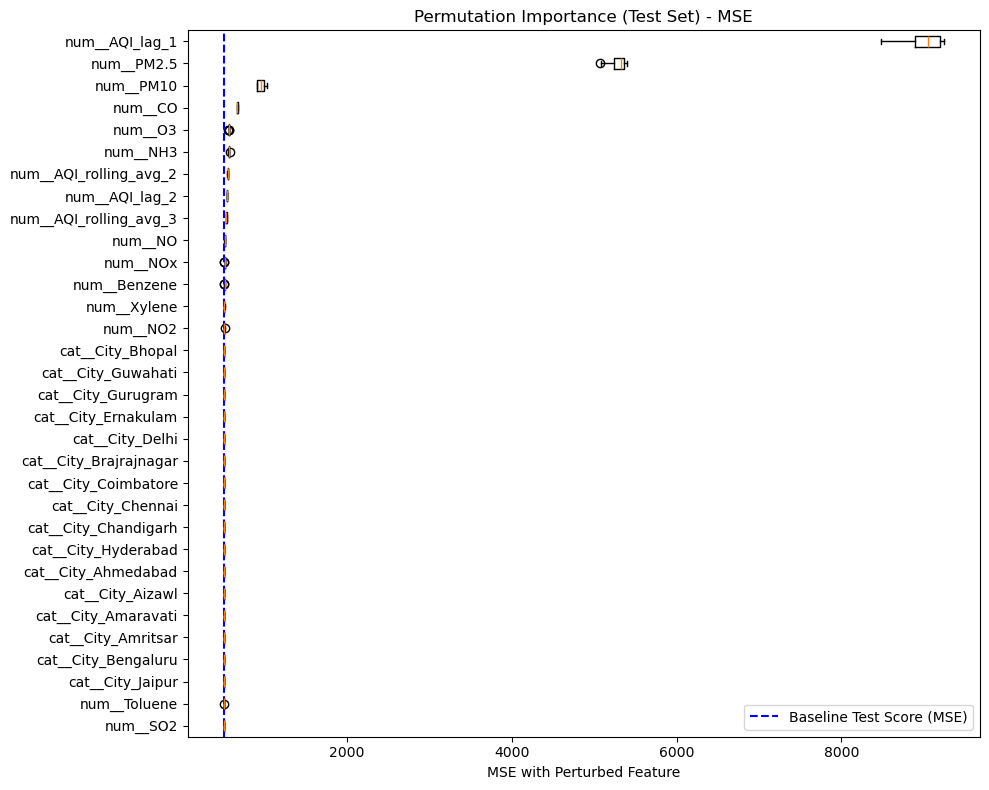

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

trained_model = RandomForestRegressor(n_estimators=500, random_state=322)

# Ensure preprocessed test data and feature names are used
X_test_preprocessed = pd.DataFrame(preprocessor.transform(X_test), columns=preprocessor.get_feature_names_out())

# Compute the baseline MSE on the unperturbed dataset
baseline_predictions = trained_model.predict(X_test_preprocessed)
baseline_mse = mean_squared_error(y_test, baseline_predictions)
print(f'Baseline Test Score (MSE): {baseline_mse:.3f}')

# Initialize parameters
np.random.seed(42)  # Set random seed for reproducibility
nr_runs = 10  # Number of runs for permutation
ftr_names = X_test_preprocessed.columns  # Feature names
scores = np.zeros([len(ftr_names), nr_runs])  # Store MSE scores for each feature

# Loop through each feature and compute permutation importance using MSE
for i, feature in enumerate(ftr_names):
    print(f'Shuffling {feature}')
    mse_scores = []
    for j in range(nr_runs):
        # Shuffle the feature and create a perturbed dataset
        X_test_shuffled = X_test_preprocessed.copy()
        X_test_shuffled[feature] = np.random.permutation(X_test_preprocessed[feature].values)
        
        # Predict and compute MSE for the perturbed dataset
        shuffled_predictions = trained_model.predict(X_test_shuffled)
        mse_scores.append(mean_squared_error(y_test, shuffled_predictions))
    
    print(f'   Shuffled test score (MSE): {np.mean(mse_scores):.3f} +/- {np.std(mse_scores):.3f}')
    scores[i] = mse_scores

# Sort features by mean importance (descending order of impact on MSE)
sorted_indices = np.argsort(np.mean(scores, axis=1))  # Larger MSE increase = more important

# Plot permutation importance
plt.figure(figsize=(10, 8))
plt.boxplot(scores[sorted_indices].T, vert=False, labels=ftr_names[sorted_indices])
plt.axvline(baseline_mse, color='blue', linestyle='--', label='Baseline Test Score (MSE)')
plt.title("Permutation Importance (Test Set) - MSE")
plt.xlabel("MSE with Perturbed Feature")
plt.legend()
plt.tight_layout()
plt.show()


In [86]:
model = RandomForestRegressor(n_estimators=500, random_state=322)

Train size: 855
Validation size: 244
Test size: 123
ADF Statistic: -3.6324782951646046
p-value: 0.005169622018093074
The series is stationary.


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA Validation MSE: 7.860918678964018e-11
SARIMA Validation R²: 0.9999999999999952
SARIMA Test MSE: 5.0179788549421216e-11
SARIMA Test R²: 0.9999999999999666


/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/anita/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version,

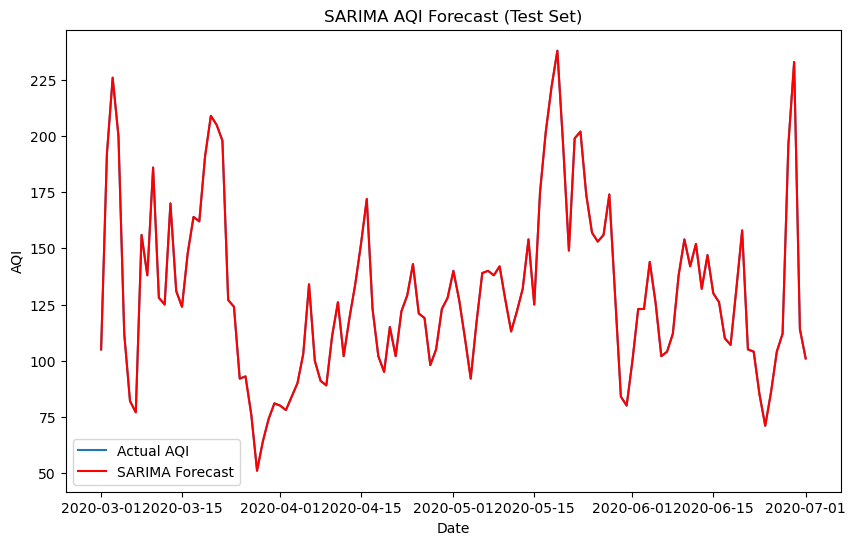

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Load and preprocess the dataset
df = pd.read_csv('city_day.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)  # Set Date as index for time series analysis

# Filter to a specific city (if applicable)
city_name = 'Delhi'  # Change this to the city of interest
df = df[df['City'] == city_name]

# Drop rows with missing AQI
df = df.dropna(subset=['AQI'])

# Step 2: Add lag and rolling average features
def add_lag_and_rolling_features(df, target_column):
    """
    Adds lag and rolling average features to the dataset.
    """
    df['lag_1'] = df[target_column].shift(1)
    df['lag_2'] = df[target_column].shift(2)
    df['rolling_avg_2'] = df[target_column].rolling(2).mean()
    df['rolling_avg_3'] = df[target_column].rolling(3).mean()
    return df

df = add_lag_and_rolling_features(df, 'AQI')

# Drop initial NaN rows created by lag/rolling features
df = df.dropna()

# Step 3: Train-Validation-Test Split (Chronological)
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 1 - train_ratio - val_ratio

n = len(df)
train_end = int(n * train_ratio)
val_end = train_end + int(n * val_ratio)

train_data = df.iloc[:train_end]
val_data = df.iloc[train_end:val_end]
test_data = df.iloc[val_end:]

# Separate target (AQI) and features
y_train = train_data['AQI']
X_train = train_data[['lag_1', 'lag_2', 'rolling_avg_2', 'rolling_avg_3', 'PM2.5', 'PM10']]

y_val = val_data['AQI']
X_val = val_data[['lag_1', 'lag_2', 'rolling_avg_2', 'rolling_avg_3', 'PM2.5', 'PM10']]

y_test = test_data['AQI']
X_test = test_data[['lag_1', 'lag_2', 'rolling_avg_2', 'rolling_avg_3', 'PM2.5', 'PM10']]

# Print dataset splits
print(f"Train size: {len(y_train)}")
print(f"Validation size: {len(y_val)}")
print(f"Test size: {len(y_test)}")

# Step 4: Check stationarity
def check_stationarity(series):
    """
    Performs the Augmented Dickey-Fuller (ADF) test to check stationarity.
    """
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary. Differencing may be required.")

check_stationarity(y_train)

# Step 5: Configure and fit the SARIMA model on train data
order = (1, 1, 2)  # ARIMA(p, d, q)
seasonal_order = (1, 1, 1, 12)  # SARIMA(P, D, Q, m)

sarima_model = SARIMAX(
    y_train,
    exog=X_train.values,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_result = sarima_model.fit(disp=False)

# Step 6: Validate on the validation set
y_val_pred = sarima_result.get_forecast(steps=len(y_val), exog=X_val.values).predicted_mean

val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
print(f"SARIMA Validation MSE: {val_mse}")
print(f"SARIMA Validation R²: {val_r2}")

# Step 7: Forecast on the test set
y_test_pred = sarima_result.get_forecast(steps=len(y_test), exog=X_test.values).predicted_mean

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"SARIMA Test MSE: {test_mse}")
print(f"SARIMA Test R²: {test_r2}")

# Step 8: Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual AQI')
plt.plot(y_test.index, y_test_pred, label='SARIMA Forecast', color='red')
plt.legend()
plt.title('SARIMA AQI Forecast (Test Set)')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.show()


